# Linear Model

In [1]:
import os

import numpy as np
import xarray as xr

from bluemath_tk.datamining.pca import PCA
from bluemath_tk.waves.estela import ESTELA, plot_defaults

from utils.data import load_atmospheric_predictor
from utils.funcs_linear import fit_plot_linear_model, plot_pcs, plot_waves

## Generate predictor

### Load MSLP fields and generate predictor

In [2]:
# Define the variables and region
variables = ["msl", "msl_gradient"]
region = (200, -10, 360, 80)
estela = False

# Load the ERA5 predictors
era5 = load_atmospheric_predictor(
    variables=variables, region=region, estela=estela
)
era5

<xarray.Dataset> Size: 145MB
Dimensions:       (time: 19684, latitude: 23, longitude: 40)
Coordinates:
  * latitude      (latitude) float32 92B 79.62 75.62 71.62 ... -4.375 -8.375
  * time          (time) datetime64[s] 157kB 1970-01-01 ... 2023-11-22
  * longitude     (longitude) float32 160B 200.4 204.4 208.4 ... 352.4 356.4
Data variables:
    msl           (time, latitude, longitude) float32 72MB 1.02e+05 ... 1.014...
    msl_gradient  (time, latitude, longitude) float32 72MB 0.0 0.0 ... 0.0 0.0

## PCA :  Principal Component Analysis

In [3]:
pca = PCA(n_components=0.9)

_pcs = pca.fit_transform(
    data=era5,
    vars_to_stack=["msl", "msl_gradient"],
    coords_to_stack=["latitude", "longitude"],
    pca_dim_for_rows="time",
    value_to_replace_nans={"msl": 101325.0, "msl_gradient": 0.0},
)
_pcs


        -------------------------------------------------------------------
        | Initializing PCA reduction model with the following parameters:
        |    - n_components: 0.9
        |    - is_incremental: False
        | For more information, please refer to the documentation.
        -------------------------------------------------------------------
        


<xarray.Dataset> Size: 14MB
Dimensions:      (time: 19684, n_component: 176)
Coordinates:
  * time         (time) datetime64[s] 157kB 1970-01-01 1970-01-02 ... 2023-11-22
  * n_component  (n_component) int64 1kB 0 1 2 3 4 5 ... 170 171 172 173 174 175
Data variables:
    PCs          (time, n_component) float32 14MB -14.74 27.34 ... 1.525 0.7444
    stds         (n_component) float32 704B 14.26 11.47 9.92 ... 1.071 1.066

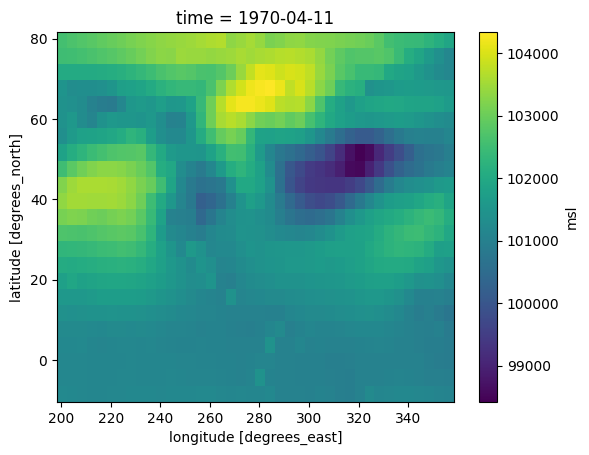

In [11]:
era5.msl.isel(time=100).plot()

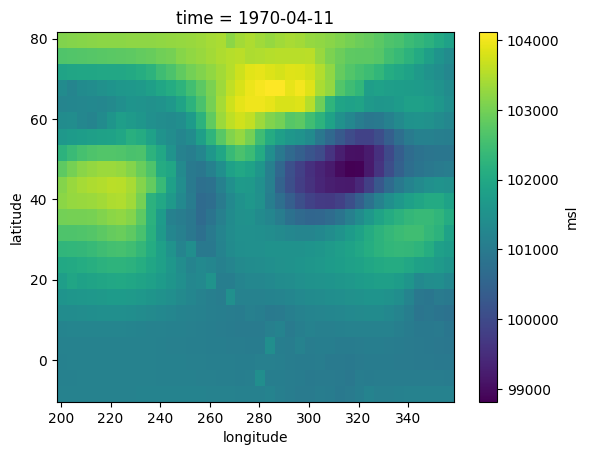

In [12]:
pca.inverse_transform(_pcs.isel(time=[100])).msl.plot()

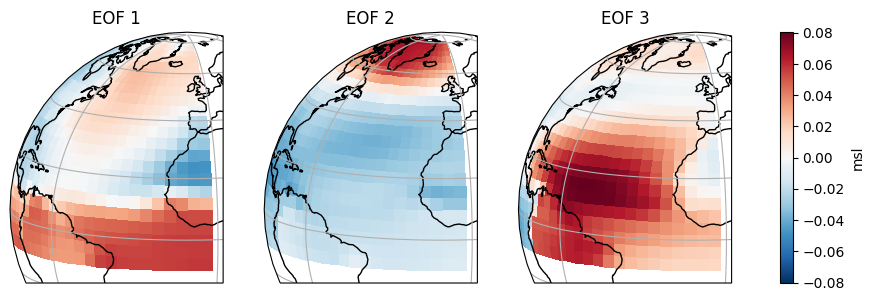

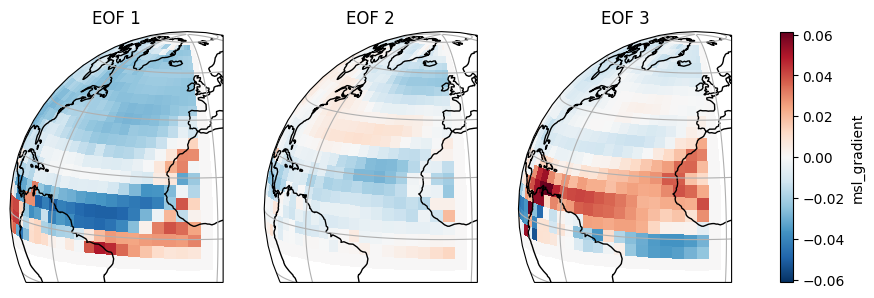

In [35]:
pca.plot_eofs(num_eofs=3, vars_to_plot=["msl", "msl_gradient"], map_center=(-10, 10))

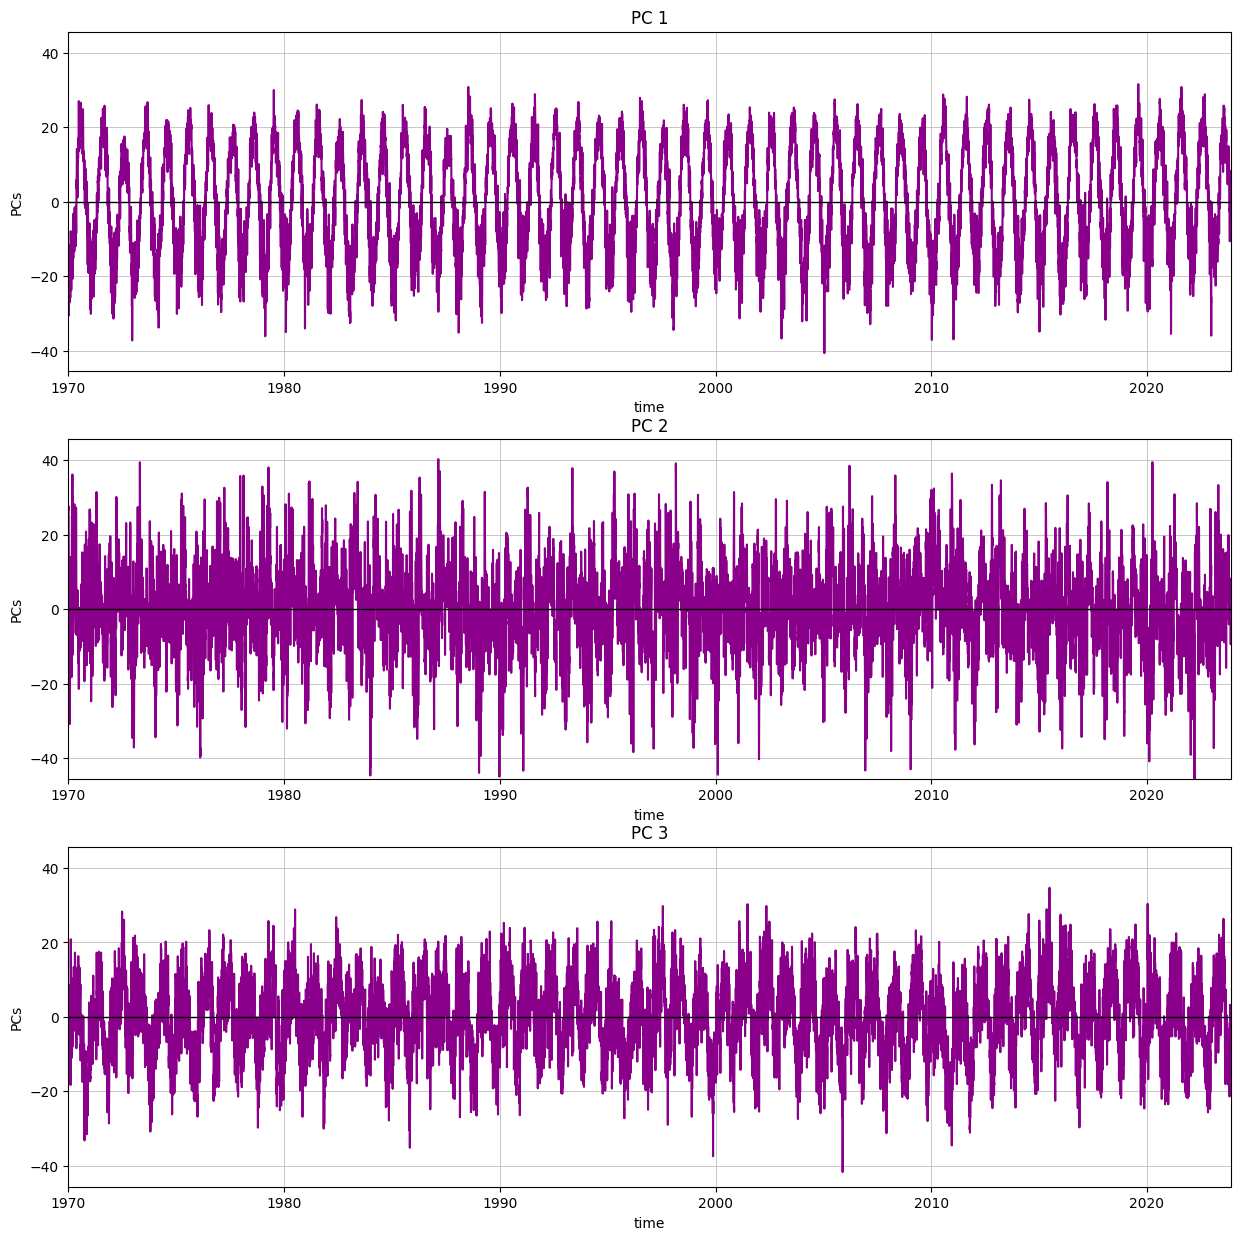

In [22]:
n_pcs = 3
plot_pcs(pca, n_pcs)

### Load Waves

In [23]:
if not os.path.exists("data/waves_EF_daily.nc"):
    waves = (
        xr.open_dataset("data/era5_aveiro.nc")[["swh", "pp1d"]].resample(time="1D").mean()
    )
    waves["EF"] = (waves["swh"] ** 2) * waves["pp1d"]
    waves = waves.drop("pp1d")
    waves.to_netcdf('data/waves_EF_daily.nc')
else:
    waves = xr.open_dataset("data/waves_EF_daily.nc")

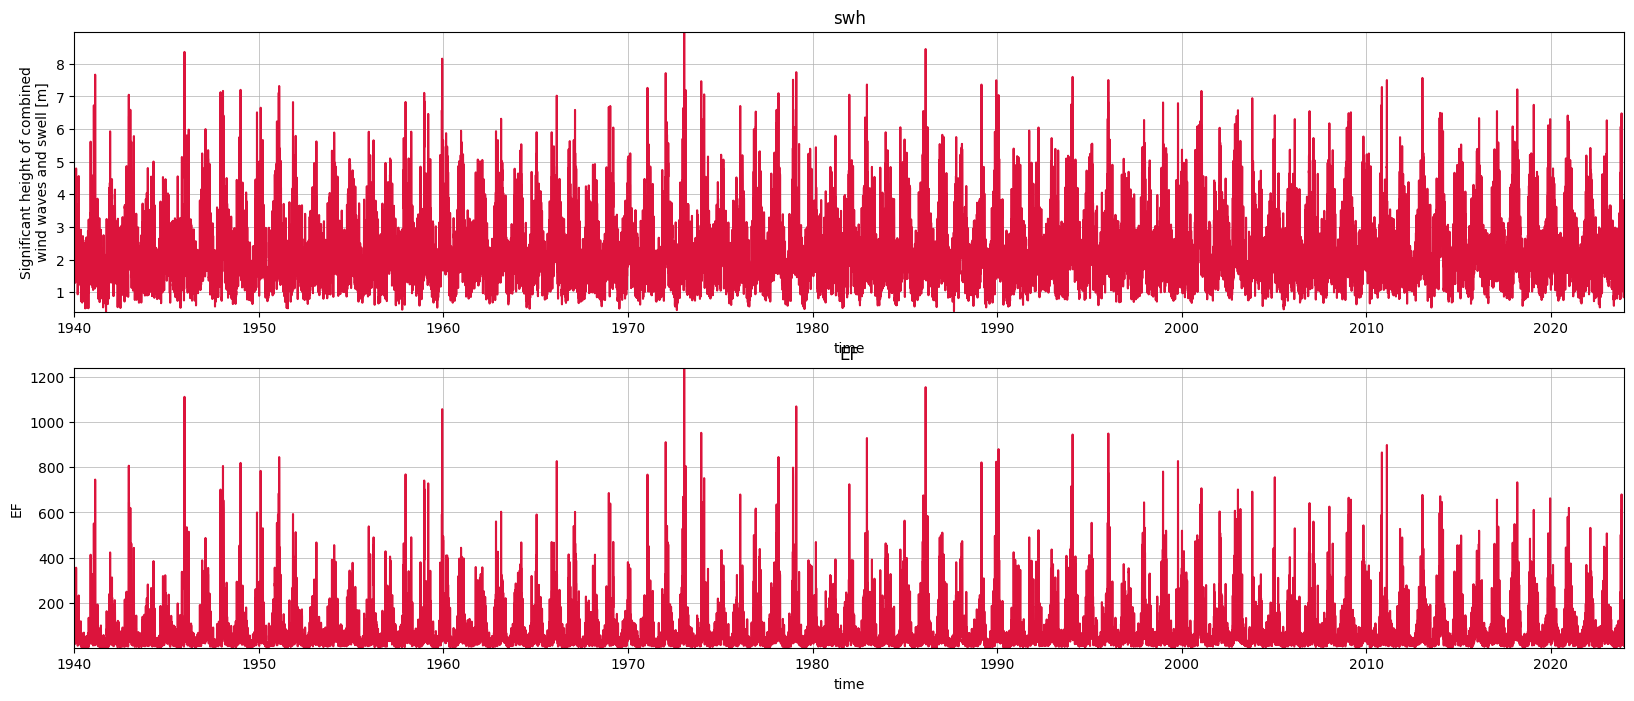

In [24]:
plot_waves(waves)

In [7]:
pca.pcs

<xarray.Dataset> Size: 14MB
Dimensions:      (time: 19684, n_component: 176)
Coordinates:
  * time         (time) datetime64[s] 157kB 1970-01-01 1970-01-02 ... 2023-11-22
  * n_component  (n_component) int64 1kB 0 1 2 3 4 5 ... 170 171 172 173 174 175
Data variables:
    PCs          (time, n_component) float32 14MB -14.74 27.34 ... 1.525 0.7444
    stds         (n_component) float32 704B 14.26 11.47 9.92 ... 1.071 1.066

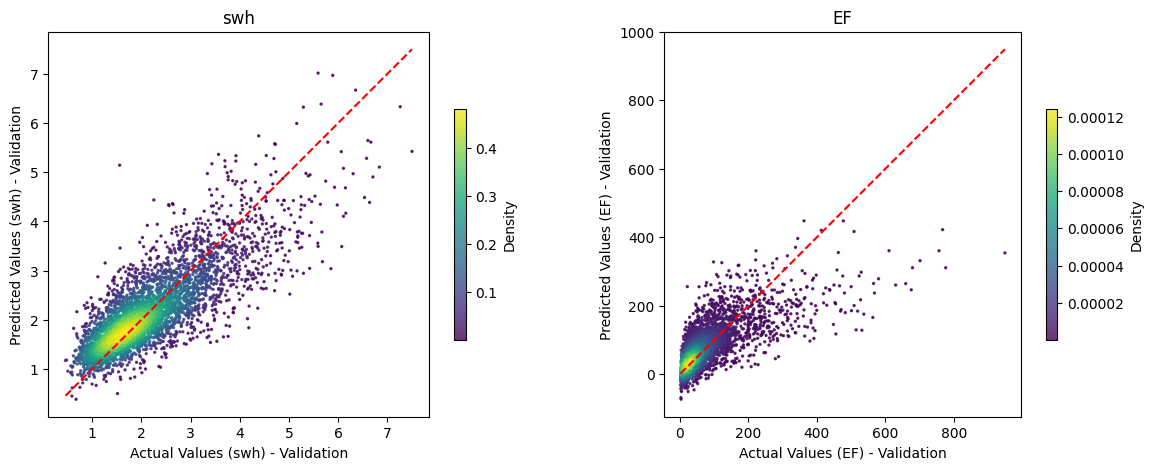

In [ ]:
n_pcs = pca.pca.n_components_  # This is the number of PCs to use as X

common_times = np.intersect1d(pca.pcs.time, waves.time)

X = pca.pcs.sel(time=common_times).PCs.isel(n_component=range(n_pcs)).values
Ys = waves.sel(time=common_times).to_dataframe()[waves.data_vars.keys()].values

fit_plot_linear_model(X, Ys, keys = list(waves.data_vars.keys()), perc_train = 0.8)

## DYNAMIC PREDICTOR

### Load ESTELA for dynamic predictor

In [9]:
ob_est = ESTELA(p_waves='', save_monthly=True, only_sea=True)
ob_est.set_site(
    site="data", location=[-8.812405 + 360, 40.645615]
)  # define lon within [0-360]
ob_est.set_years(years=[1980, 2024])
ob_est.get_estela(
    do_estela=False
)  # If do_estela = False  it will only load the previously executed estela

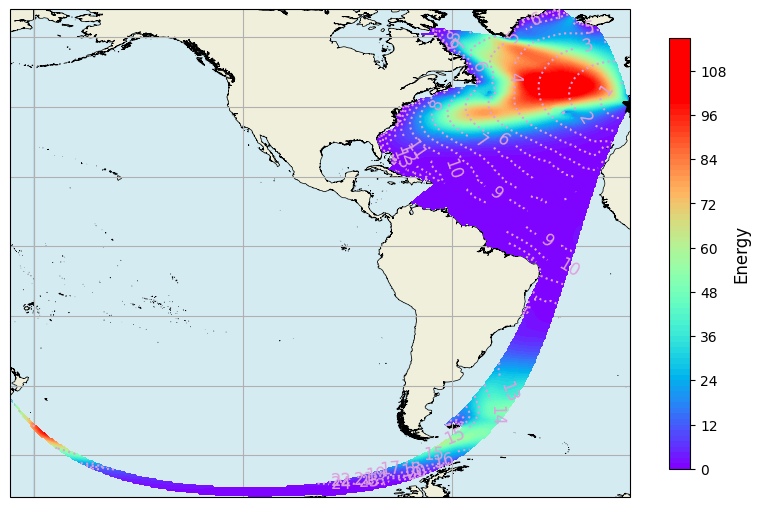

In [10]:
ob_est.plot_mean_estela(
    custom_params={"central_longitude": ob_est.lon0, "vmax": 100, "figsize": [10, 8]}
);

In [29]:
# Define the variables and region
variables = ["msl", "msl_gradient"]
region = (200, -10, 360, 80)
estela = True

# Load the ERA5 predictors
era5_dynamic = load_atmospheric_predictor(
    variables=variables, region=region, estela=estela
)
era5_dynamic

2025-04-03 09:08:07,906 - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-04-03 09:08:07,927 - INFO - State start
2025-04-03 09:08:07,929 - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-iqh6048u', purging
2025-04-03 09:08:07,930 - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dqzejqa8', purging
2025-04-03 09:08:07,931 - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-7j5mhcki', purging
2025-04-03 09:08:07,932 - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-7xd2jv76', purging
2025-04-03 09:08:07,933 - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ci6m77l3', purging
2025-04-03 09:08:07,936 - INFO -   Scheduler at:     tcp://127.0.0.1:41755
2025-04-03 09:08:07,936 - INFO -   dashboard at:  http://127.0.0.1:8787/status
2025-04-03 09:08:07,937 - INFO - Registeri

<xarray.Dataset> Size: 145MB
Dimensions:       (time: 19684, latitude: 23, longitude: 40)
Coordinates:
  * latitude      (latitude) float32 92B 79.62 75.62 71.62 ... -4.375 -8.375
  * time          (time) datetime64[s] 157kB 1970-01-01 ... 2023-11-22
  * longitude     (longitude) float32 160B 200.4 204.4 208.4 ... 352.4 356.4
Data variables:
    msl           (time, latitude, longitude) float32 72MB nan nan ... nan nan
    msl_gradient  (time, latitude, longitude) float32 72MB nan nan ... nan nan

## PCA :  Principal Component Analysis

In [30]:
pca_dynamic = PCA(n_components=0.95)

pca_dynamic.fit_transform(
    data=era5_dynamic,
    vars_to_stack=["msl", "msl_gradient"],
    coords_to_stack=["latitude", "longitude"],
    pca_dim_for_rows="time",
    value_to_replace_nans={"msl": 101325.0, "msl_gradient": 0.0},
)

2025-04-03 09:09:57,407 - PCA - WARNING - Data contains NaNs.


2025-04-03 09:09:57,451 - PCA - WARNING - Data contains NaNs.



        -------------------------------------------------------------------
        | Initializing PCA reduction model with the following parameters:
        |    - n_components: 0.95
        |    - is_incremental: False
        | For more information, please refer to the documentation.
        -------------------------------------------------------------------
        


<xarray.Dataset> Size: 11MB
Dimensions:      (time: 19684, n_component: 142)
Coordinates:
  * time         (time) datetime64[s] 157kB 1970-01-01 1970-01-02 ... 2023-11-22
  * n_component  (n_component) int64 1kB 0 1 2 3 4 5 ... 136 137 138 139 140 141
Data variables:
    PCs          (time, n_component) float32 11MB -17.03 5.321 ... 0.3065
    stds         (n_component) float32 568B 7.228 7.105 5.076 ... 0.5691 0.5636

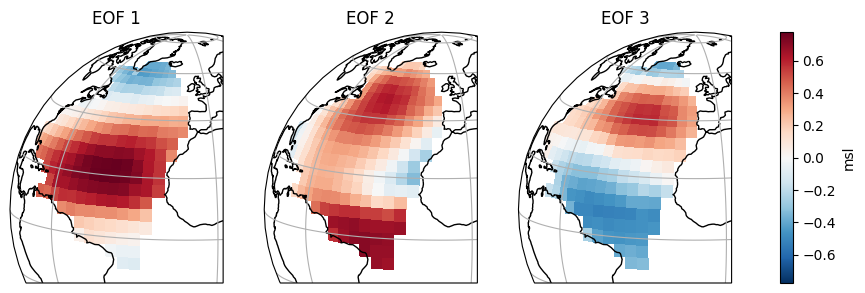

In [34]:
pca_dynamic.plot_eofs(num_eofs=3, vars_to_plot=["msl"], destandarize=True, map_center=(-10, 10))

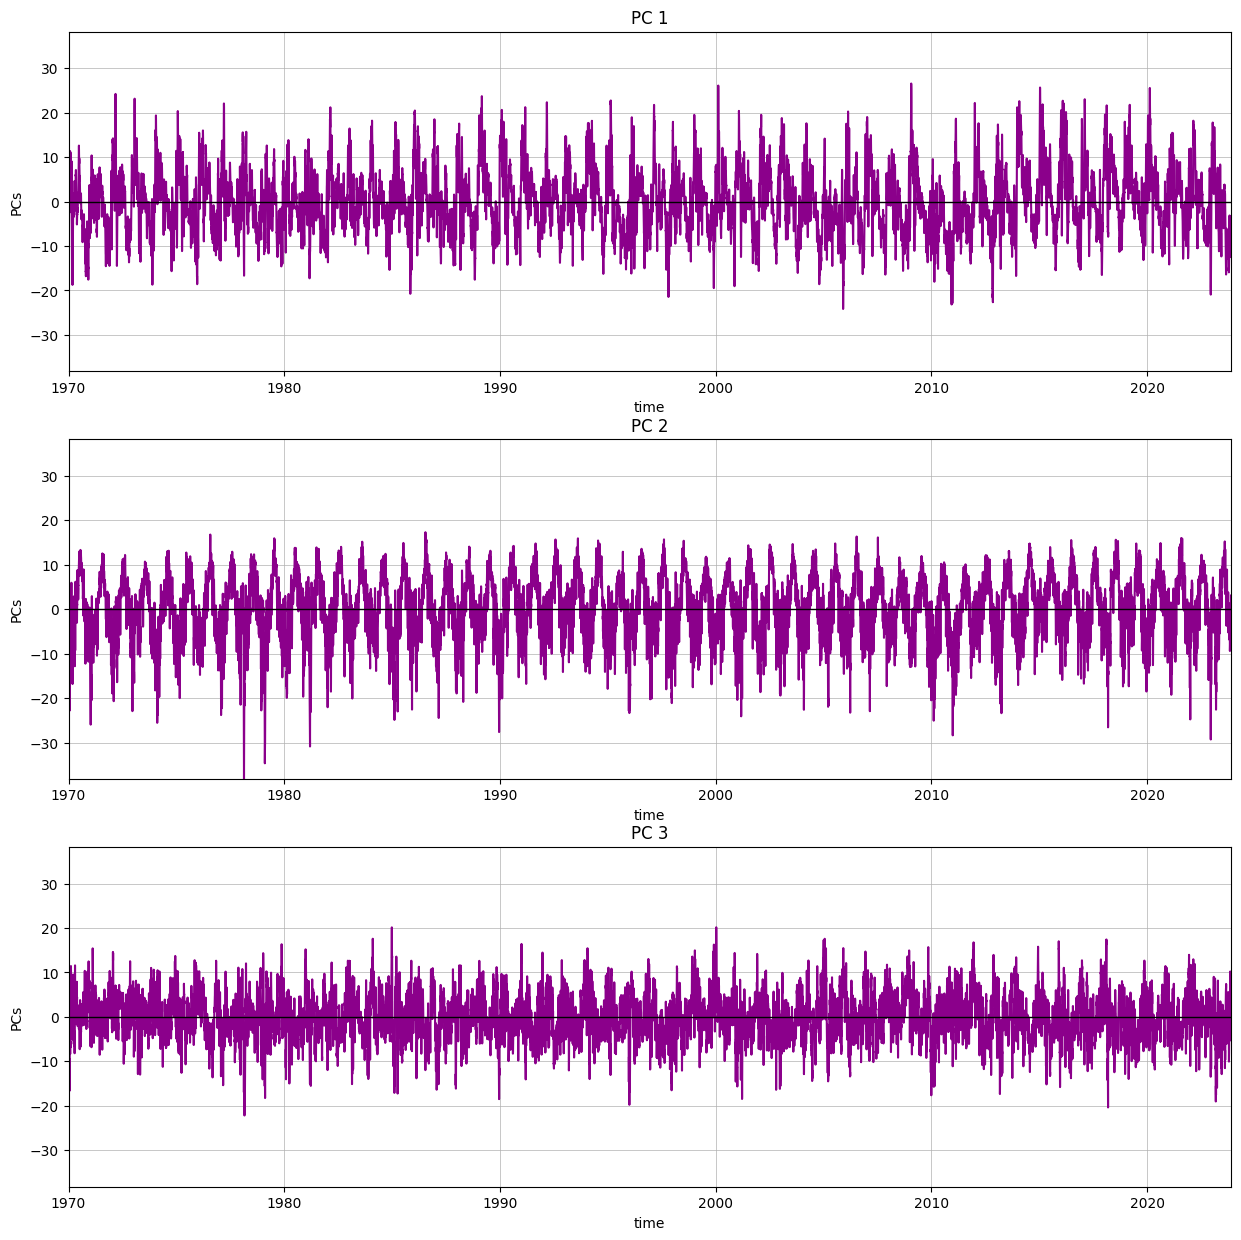

In [31]:
n_pcs = 3
plot_pcs(pca_dynamic, n_pcs)

In [14]:
pca_dynamic.pcs

<xarray.Dataset> Size: 11MB
Dimensions:      (time: 19684, n_component: 142)
Coordinates:
  * time         (time) datetime64[s] 157kB 1970-01-01 1970-01-02 ... 2023-11-22
  * n_component  (n_component) int64 1kB 0 1 2 3 4 5 ... 136 137 138 139 140 141
Data variables:
    PCs          (time, n_component) float32 11MB -17.03 5.321 ... 0.3065
    stds         (n_component) float32 568B 7.228 7.105 5.076 ... 0.5691 0.5636

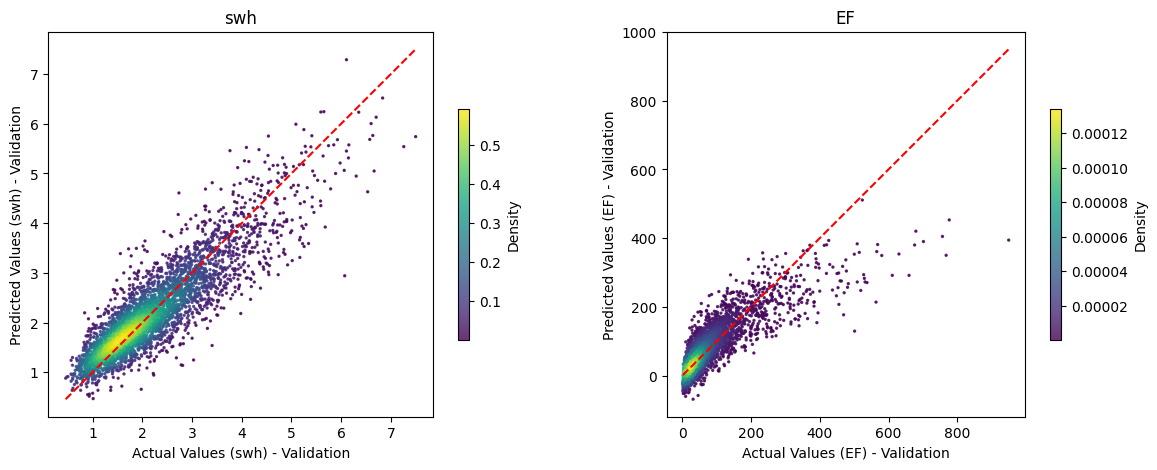

In [15]:
n_pcs = pca_dynamic.pca.n_components_

common_times = np.intersect1d(pca_dynamic.pcs.time, waves.time)

X = pca_dynamic.pcs.sel(time=common_times).PCs.isel(n_component=range(n_pcs)).values
Ys = waves.sel(time=common_times).to_dataframe()[waves.data_vars.keys()].values

fit_plot_linear_model(X, Ys, keys = list(waves.data_vars.keys()), perc_train = 0.8)